# Process traces

First runs scripts/notebooks `2_calibration` and `3_traces`.  Then
calculate for each trace:
- concentration
- discharge
- times of peaks
- background and peak concentrations

Writes output to ../data/products/example/output.csv (change "example" to the current year)

Load "3_traces.jl" (also loads 2_calibration.jl and helper_functions.jl)

In [1]:
using NBInclude
@nbinclude("3_traces.ipynb")
# set to false to get interactive plots, false for in-line plots
Makie.inline!(true)

Estimated linear fit: f(delta_cond) = a*conc with
 a = 0.000818±2.8e-5

Estimated linear fit: f(delta_cond) = a*conc with
 a = 0.000812±9.9e-5

Estimated linear fit: f(delta_cond) = a*conc with
 a = 0.000456±5.18e-6



┌ Warning: No data for sensor 309
└ @ Main C:\Users\herol\julia\GlacierHydroFieldcourse.jl\notebooks\3_traces.ipynb:In[4]:26
┌ Warning: No data for sensor 309
└ @ Main C:\Users\herol\julia\GlacierHydroFieldcourse.jl\notebooks\3_traces.ipynb:In[4]:26
┌ Warning: No data for sensor 309
└ @ Main C:\Users\herol\julia\GlacierHydroFieldcourse.jl\notebooks\3_traces.ipynb:In[4]:26
┌ Warning: No data for sensor 309
└ @ Main C:\Users\herol\julia\GlacierHydroFieldcourse.jl\notebooks\3_traces.ipynb:In[4]:26
┌ Warning: No data for sensor 309
└ @ Main C:\Users\herol\julia\GlacierHydroFieldcourse.jl\notebooks\3_traces.ipynb:In[4]:26
┌ Warning: No data for sensor 309
└ @ Main C:\Users\herol\julia\GlacierHydroFieldcourse.jl\notebooks\3_traces.ipynb:In[4]:26
┌ Warning: No data for sensor 309
└ @ Main C:\Users\herol\julia\GlacierHydroFieldcourse.jl\notebooks\3_traces.ipynb:In[4]:26
┌ Warning: No data for sensor 309
└ @ Main C:\Users\herol\julia\GlacierHydroFieldcourse.jl\notebooks\3_traces.ipynb:In[4]:26


true

Make the processing-function (see their doc-string for more info)

In [20]:
using Statistics

"""
    make_concentration!(tr, num=15)

Calculate the concentration for a trace.  Assume that the first
`num` (3 by default) values are background and use that as an average.

Updates the trace in-place
"""
function make_concentration!(tr, num=3)
    for (loc, v) in tr.sensors
        if length(v)<2
            continue
        end
        tr.products[loc] = Dict()
        conc = v[:cali_fn](v[:cond])
        bkg = mean(conc[1:num])
        tr.products[loc]
        tr.sensors[loc][:conc] = conc .- bkg
        tr.products[loc][:background] = bkg
    end
    return nothing
end

"""
    integrate_concentration(t, conc, minconc=0.0)

Integrates the concentration time series.

Input:
- t -- times (s)
- conc -- concentration (g/l) time series (convert conductivity with f_readout2conc
          to a concentration)
- minconc -- if concentration drops below this value, discard that value.  Useful to
             discard values which are before/after the sensor is in the water.

Output:

- integrated concentration (g s/l) == (kg s/ m^3)
"""
function integrate_concentration(t, conc, minconc=0.0)
    inds = conc.>minconc
    dt = t[2]-t[1]
    return sum(conc[inds]*dt) # approximate the integral by a sum
end

function integrate_concentration_trapez(t, conc, minconc=0.0)
    inds = conc.>minconc
    conc_valid = conc[inds]
    dt = t[2]-t[1]
    return sum( (conc_valid[1:end-1] + conc_valid[2:end])/2 *dt) # approximate the integral by a sum of trapezoids
end

"""
    process_trace!(tr)

Process one trace at each sensor location/for each sensor:
- make concentration time series
- record background
- calc Q
- get peak concentration & time
"""
function process_trace!(tr)
    make_concentration!(tr)
    for (loc, v) in tr.sensors
        if length(v)<2
            continue
        end
        # calc discharge (m3/s)
        Q = tr.mass/1000/integrate_concentration(tr.sensors[loc][:tsec], tr.sensors[loc][:conc])
        tr.products[loc][:Q] = round(Q, sigdigits=2)
        # get time of peak in secs after injection
        peak_val, peak_ind = findmax(tr.sensors[loc][:conc])
        tr.products[loc][:peak_time] = tr.sensors[loc][:tsec][peak_ind]
        tr.products[loc][:peak_value] = peak_val
    end
    return nothing
end;

function process_trace_trapez!(tr)
    make_concentration!(tr)
    for (loc, v) in tr.sensors
        if length(v)<2
            continue
        end
        # calc discharge (m3/s)
        Q = tr.mass/1000/integrate_concentration_trapez(tr.sensors[loc][:tsec], tr.sensors[loc][:conc])
        tr.products[loc][:Q] = round(Q, sigdigits=2)
        # get time of peak in secs after injection
        peak_val, peak_ind = findmax(tr.sensors[loc][:conc])
        tr.products[loc][:peak_time] = tr.sensors[loc][:tsec][peak_ind]
        tr.products[loc][:peak_value] = peak_val
    end
    return nothing
end;

Run the processing on all traces and plot a trace in terms of
concentration:

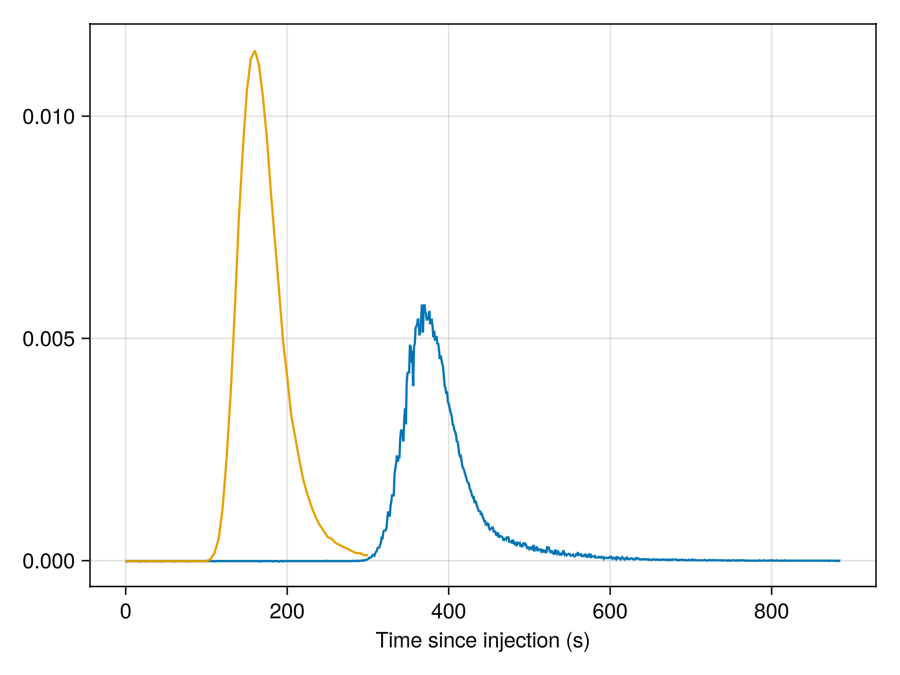

In [23]:
for trace in traces
    process_trace_trapez!(trace)
end
plot_trace(traces[5], :conc)

Write output CSV

In [22]:
function write_output(traces, fl)
    out = [["Experiment No", "Location", "Date" , "Injection time", "End time", "Salt mass [g]",
            145, 049, 309, "Q1", "Q2", "Q3", "t1", "t2", "t3"]]
    for tr in traces

        locdict = Dict(v[:sensor_name]=>k for (k,v) in tr.sensors)
        push!(out, [tr.nr, tr.location,  Dates.format(tr.tinj, "dd.mm.yyyy"), Dates.format(tr.tinj, "HH:MM:SS"),
                    Dates.format(tr.tend, "HH:MM:SS"), tr.mass,
                    get(locdict,:s145,"x"),
                    get(locdict,:s049,"x"),
                    get(locdict,:s309,"x"),
                    get(tr.products, 1, Dict(:Q=>NaN))[:Q],
                    get(tr.products, 2, Dict(:Q=>NaN))[:Q],
                    get(tr.products, 3, Dict(:Q=>NaN))[:Q],
                    get(tr.products, 1, Dict(:peak_time=>NaN))[:peak_time],
                    get(tr.products, 2, Dict(:peak_time=>NaN))[:peak_time],
                    get(tr.products, 3, Dict(:peak_time=>NaN))[:peak_time]])
    end
    writedlm(fl, out, ',')
end

write_output(traces, "../data/products/2024_Konki/output_Trapez.csv")

This produces a CSV output file with the headers

`Experiment No,Location,Date,Injection time,End time,Salt mass [g],145,49,309,Q1,Q2,Q3,t1,t2,t3`

i.e. similar to the input `tracer_metadata.csv` but with added discharges and time-of-peak for
each sensor [`output.csv`](../data/example_pro/output.csv).  It's located in `../data/example_pro/`,
for your output data you should make a folder such as `../data/products/2021`.

---

*This notebook was generated using [Literate.jl](https://github.com/fredrikekre/Literate.jl).*